In [1]:
import tcav.utils_plot as utils_plot
from tcav.utils import pickle_load
from config import root_dir, model_to_run, bottlenecks, concepts, version, num_random_exp, max_examples, run_parallel, num_workers
import matplotlib.pyplot as plt
import numpy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import itertools
from tcav.utils_analysis import get_cav_mean, get_true_cav_mean, get_sensitivity, get_score, get_predict, get_grad, get_logit_grad, cos_sim, get_cav
import importlib

In [6]:
project_names = '2layers-mnist-number_10'
#project_names = '2layers-colored-mnist-number_10'
keyword = '0'
#keyword = 'nomal'
exceptword = 'logit_grad'
results_lst = []
cavs_path = root_dir + 'log/' + project_names + '/cavs/'

# results(random同士なし)をロード
results_path = os.listdir(root_dir + 'log/' + project_names + '/tcavs')
results_path.sort()
for path in results_path:
    if keyword in path and exceptword not in path:
        results = pickle_load(root_dir + 'log/' + project_names + '/tcavs/' + path)
        results_lst.append(results)
        print(path)

conv1_conv2:-mnist-0:imagenet-blue_imagenet-green_imagenet-red_imagenet-purple_imagenet-yellow_50_0704
conv1_conv2:-mnist-0:roundness_straight_sharpness_50_0711
conv1_conv2:-mnist-1:imagenet-blue_imagenet-green_imagenet-red_imagenet-purple_imagenet-yellow_50_0704
conv1_conv2:-mnist-1:roundness_straight_sharpness_50_0711
conv1_conv2:-mnist-4:imagenet-blue_imagenet-green_imagenet-red_imagenet-purple_imagenet-yellow_50_0704
conv1_conv2:-mnist-4:roundness_straight_sharpness_50_0711
conv1_conv2:-mnist-6:imagenet-blue_imagenet-green_imagenet-red_imagenet-purple_imagenet-yellow_50_0704
conv1_conv2:-mnist-6:roundness_straight_sharpness_50_0711
conv1_conv2:blue-mnist-0:imagenet-blue_50_0704
conv1_conv2:blue-mnist-5:imagenet-blue_50_0704
conv1_conv2:green-mnist-4:imagenet-green_50_0704
conv1_conv2:green-mnist-9:imagenet-green_50_0704
conv1_conv2:purple-mnist-3:imagenet-purple_50_0704
conv1_conv2:purple-mnist-8:imagenet-purple_50_0704
conv1_conv2:red-mnist-2:imagenet-red_50_0704
conv1_conv2:red-m

## TCAV スコア

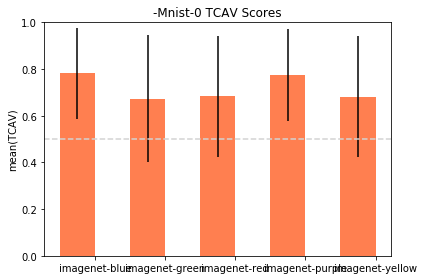

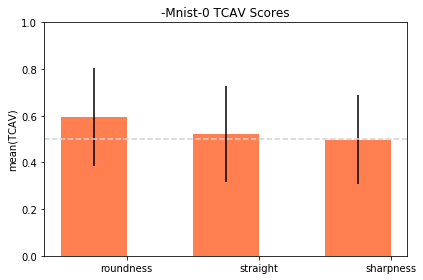

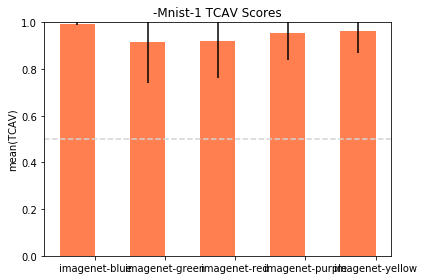

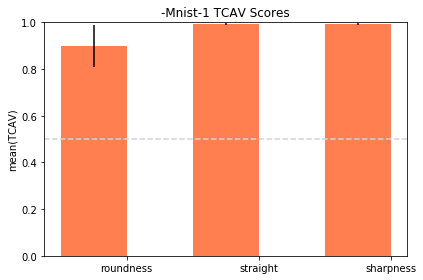

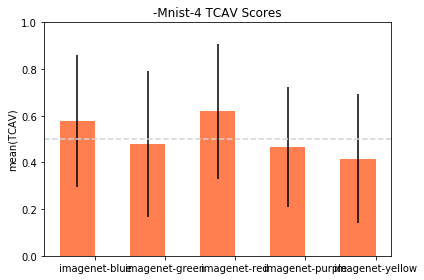

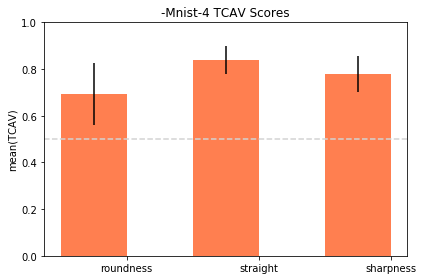

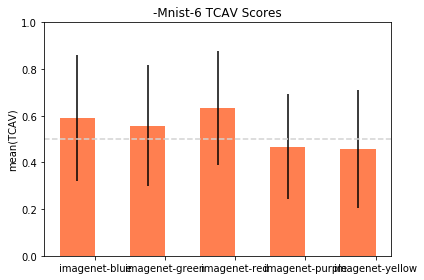

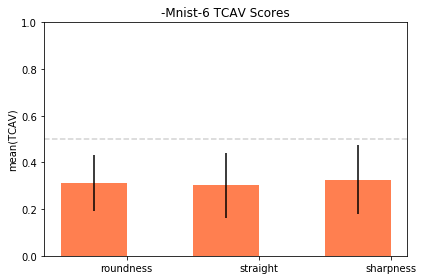

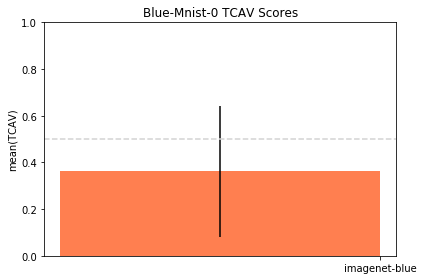

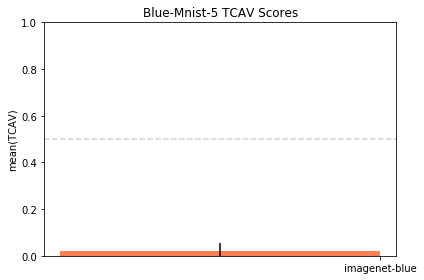

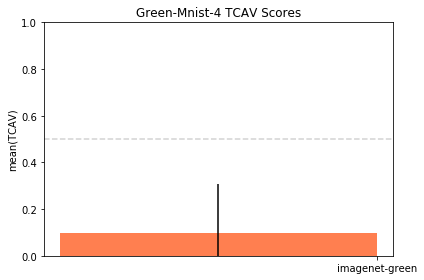

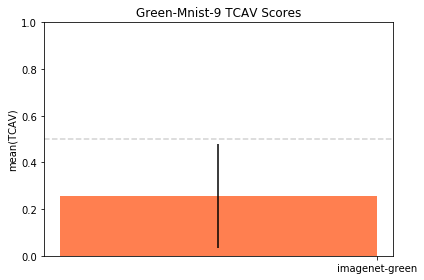

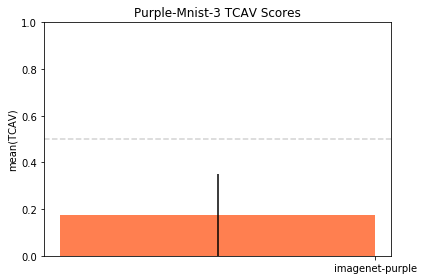

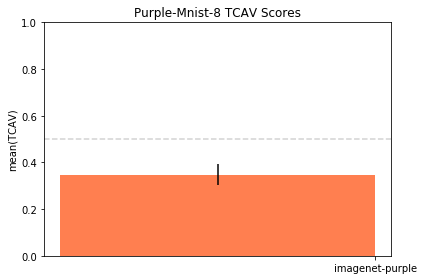

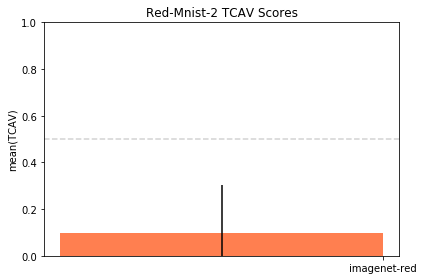

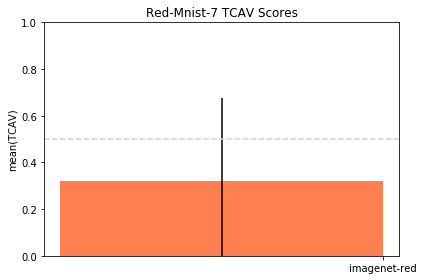

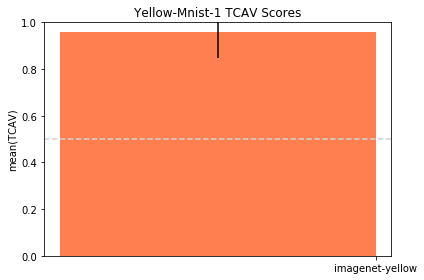

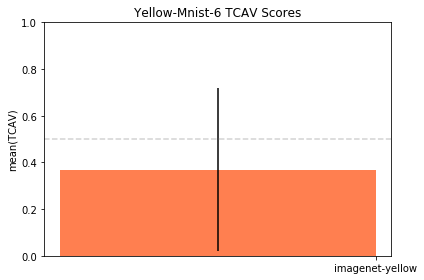

In [7]:
importlib.reload(utils_plot)

is_bonferroni = False
for i,results in enumerate(results_lst):
    #utils_plot.plot_concept_results(results, root_dir + 'log/' + project_names + '/plot',keyword=keyword+'_'+str(i))
    utils_plot.plot_concept_results(results)

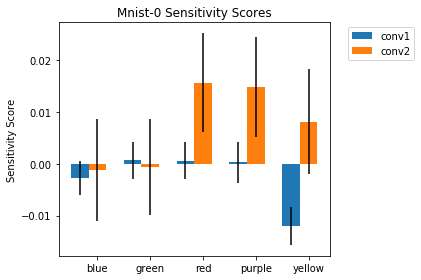

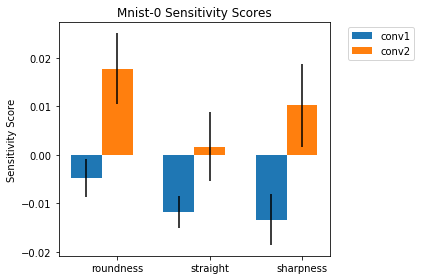

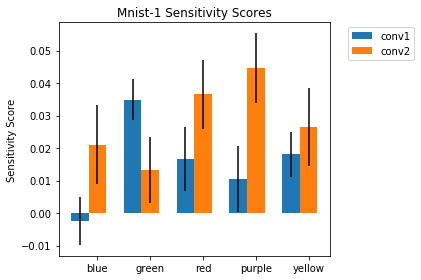

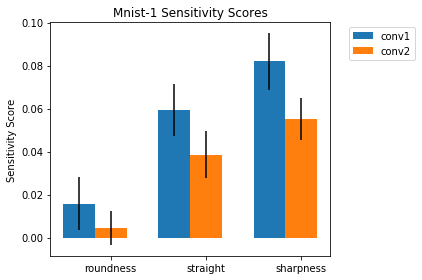

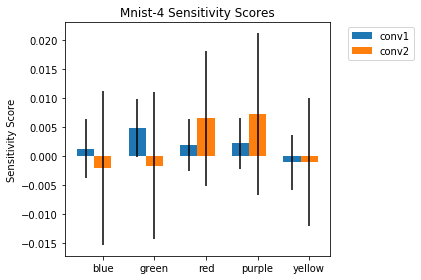

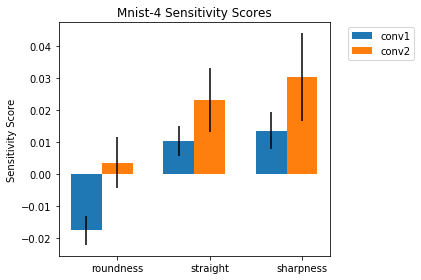

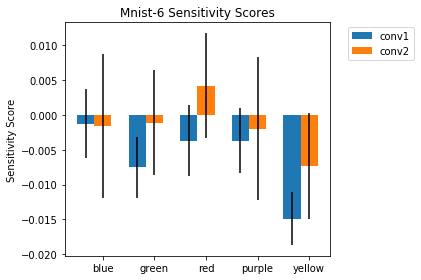

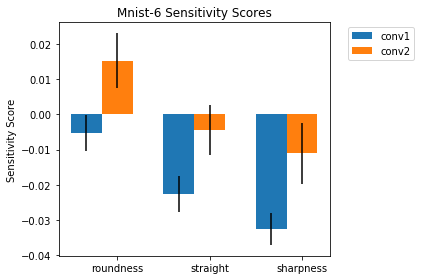

In [40]:
importlib.reload(utils_plot)
for i,results in enumerate(results_lst):
    utils_plot.plot_concept_sensitivity(results)
    #utils_plot.plot_concept_sensitivity(results, root_dir + 'log/' + project_names + '/plot',keyword=keyword+'_'+str(i))

### CAVの類似度を算出

In [4]:
#lst = []
#concepts = ['mnist_0','mnist_1','mnist_2','mnist_3','mnist_4','mnist_5','mnist_6','mnist_7','mnist_8','mnist_9']
concepts = ['simple-blue','simple-green','simple-red','simple-yellow','simple-purple']
bottleneck = 'conv1'
for v in itertools.combinations(concepts, 2):
    print('---------------------')
    print(f'{v[0]} vs {v[1]}')
    print(np.round(cos_sim(get_cav_mean(cavs_path, bottleneck, v[0]),get_cav_mean(cavs_path, bottleneck, v[1])),2))
    # tmp = np.round(cos_sim(get_cav_mean('cav',cavs_path, bottleneck, v[0]),get_cav_mean('cav',cavs_path, bottleneck, v[1])),2)
    # print(tmp)
    # lst.append(tmp)
# print(np.round(np.mean(lst),2))
# print(np.round(np.std(lst),2))
# print(np.round(np.min(lst),2))
# print(np.round(np.max(lst),2))

---------------------
simple-blue vs simple-green
-0.24
---------------------
simple-blue vs simple-red
0.13
---------------------
simple-blue vs simple-yellow
-0.81
---------------------
simple-blue vs simple-purple
0.74
---------------------
simple-green vs simple-red
0.04
---------------------
simple-green vs simple-yellow
0.34
---------------------
simple-green vs simple-purple
-0.37
---------------------
simple-red vs simple-yellow
0.01
---------------------
simple-red vs simple-purple
0.65
---------------------
simple-yellow vs simple-purple
-0.7


### 各指標の計算

In [ ]:
# mnist-5 imagenet-yellow conv1
# mnist-4 imagenet-purple conv2

In [17]:
#name = '2layers-mnist-number_conv1_conv2:mnist-4:imagenet-blue_imagenet-green_imagenet-red_imagenet-purple_imagenet-yellow_50_0629'
name = 'logitgrad-2layers-colored-mnist-number_10_conv1_conv2:mnist-0:imagenet-blue_imagenet-green_imagenet-red_imagenet-purple_imagenet-yellow_50_0704'
#name = '2layers-mnist-number_conv1_conv2:mnist-5:roundness_straight_sharpness_50_0629'
results_path = root_dir + 'log/' + project_names + '/tcavs/' + name
#bottlenecks = ['conv1','conv2']
#targets = ['mnist-0','mnist-1','mnist-4','mnist-5','mnist-6','mnist-7']
targets = ['mnist-0']
#concepts = ['imagenet-blue','imagenet-green','imagenet-red','imagenet-purple','imagenet-yellow']
concepts = ['roundness','straight','sharpness','imagenet-blue','imagenet-green','imagenet-red','imagenet-purple','imagenet-yellow']
bottlenecks = ['conv2']
target = results_path.split('/')[-1].split(':')[1]

# sensitivity = get_sensitivity(pickle_load(results_path), concept, bottleneck)
# score = get_score(pickle_load(results_path), concept, bottleneck)
# grad = get_grad(cavs_path, bottleneck,target)
# logit_grad = get_logit_grad(cavs_path, bottleneck, target)
cav = get_cav(cavs_path, bottleneck, concept)

## sensitivity

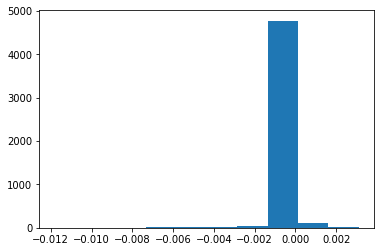

In [27]:
for i, s in enumerate(sensitivity):
    if i == 0:
        sen = s
    else:
        sen = np.append(sen,s)
plt.hist(sen);

## grad

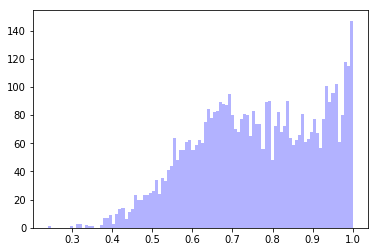

In [28]:
sim_lst = []
for v in itertools.combinations(np.arange(len(grad)), 2):
    sim = cos_sim(logit_grad[v[0]],logit_grad[v[1]])
    sim_lst.append(sim)
plt.hist(sim_lst, bins=100, alpha=0.3, histtype='stepfilled', color='b');

In [18]:
for target in targets:
    sim_all = []
    for bottleneck in bottlenecks:
        logit_grad = get_logit_grad(cavs_path, bottleneck, target)
        sim_lst = []
        for v in itertools.combinations(np.arange(len(grad)), 2):
            sim = cos_sim(logit_grad[v[0]],logit_grad[v[1]])
            sim_lst.append(sim)
        sim_all.append(sim_lst)
    plt.title('Cos Similarity in combination of ' + target +  ' examples')
    plt.hist(sim_all[0], bins=100, alpha=0.3, histtype='stepfilled', color='b',label=bottlenecks[0])
    plt.hist(sim_all[1], bins=100, alpha=0.3, histtype='stepfilled', color='r',label=bottlenecks[1])
    plt.xlabel('cos_similarity')
    plt.ylim(0,1400)
    plt.legend()
    #plt.savefig(root_dir + 'log/' + project_names + '/plot/grad_simi'+target)
    plt.show()

NameError: name 'grad' is not defined

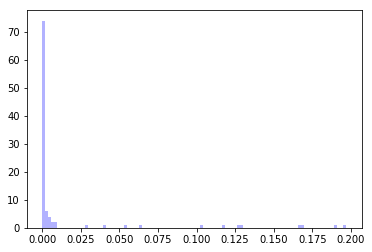

In [118]:
logit_grad_l2 = [np.linalg.norm(lg, ord=2) for lg in logit_grad]
plt.hist(logit_grad_l2, bins=100, alpha=0.3, histtype='stepfilled', color='b');
plt.savefig(root_dir + 'log/' + project_names + '/plot/logit_grad_l2')

## cav

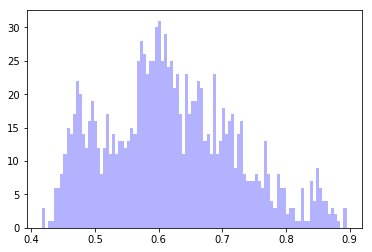

In [9]:
sim_cav_lst = []
for v in itertools.combinations(np.arange(len(cav)), 2):
    sim = cos_sim(cav[v[0]],cav[v[1]])
    sim_cav_lst.append(sim)
plt.hist(sim_cav_lst, bins=100, alpha=0.3, histtype='stepfilled', color='b');

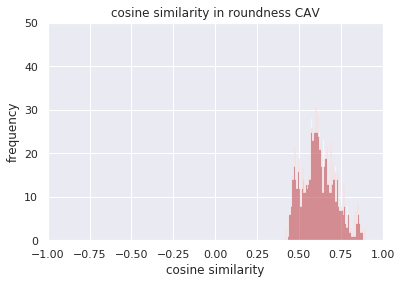

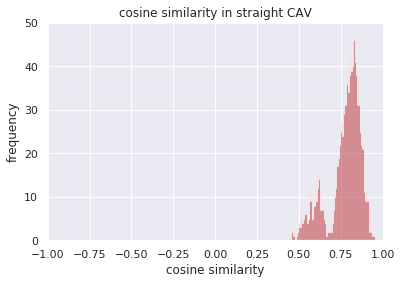

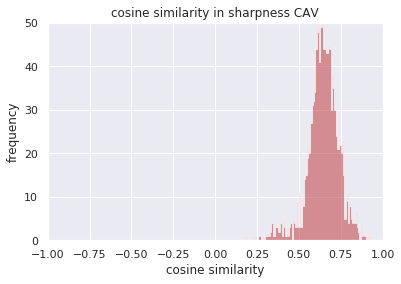

In [43]:
import seaborn as sns
sns.set()
#concepts = ['imagenet-blue','imagenet-green','imagenet-red','imagenet-purple','imagenet-yellow']
concepts = ['roundness','straight','sharpness']
simi_all_dct = {}
for concept in concepts:
    sim_all = []
    for bottleneck in bottlenecks:
        cav = get_cav(cavs_path, bottleneck, concept)
        sim_lst = []
        for v in itertools.combinations(np.arange(len(cav)), 2):
            sim = cos_sim(cav[v[0]],cav[v[1]])
            sim_lst.append(sim)
        sim_all.append(sim_lst)
    simi_all_dct[concept] = sim_all
    if 'imagenet' in concept:
        concept = concept.split('-')[1]
    plt.title('cosine similarity in ' + concept +  ' CAV')
    plt.hist(sim_all[0], bins=100, alpha=0.6, histtype='stepfilled', color='r',label=bottlenecks[0])
    #plt.hist(sim_all[1], bins=100, alpha=0.3, histtype='stepfilled', color='r',label=bottlenecks[1])
    plt.xlabel('cosine similarity')
    plt.ylim(0,50)
    plt.xlim(-1,1)
    plt.ylabel('frequency')
    #plt.legend()
    plt.savefig(root_dir + 'log/' + project_names + '/plot/cav_simi_hist-'+concept + '.eps')
    plt.show()


In [15]:
simi_all_dct.keys()

dict_keys(['roundness', 'straight'])

### logit_gradとCAVのCos類似度

In [54]:
bottlenecks = ['conv2']
#targets = ['mnist-0','mnist-1','mnist-4','mnist-5','mnist-6']
targets = ['mnist-0']
concepts = ['imagenet-blue','imagenet-green','imagenet-red','imagenet-purple','imagenet-yellow']
#concepts = ['roundness','straight','sharpness']
simirarity_score = {}
for target in targets:
    simirarity_score[target] = {}
    for concept in concepts:
        for bottleneck in bottlenecks:
            if bottleneck not in simirarity_score[target]:
                simirarity_score[target][bottleneck] = {}
                simirarity_score[target][bottleneck]['mean'] = []
                simirarity_score[target][bottleneck]['std'] = []
            logit_grad = get_logit_grad(cavs_path, bottleneck, target)
            cav = get_cav(cavs_path, bottleneck, concept)
            s_simi_lst = []
            for c in cav:
                s_simi = np.array([cos_sim(lg,c) for lg in logit_grad])
                s_simi_lst.append(s_simi)
            simirarity_score[target][bottleneck]['mean'].append(np.median(s_simi_lst))
            simirarity_score[target][bottleneck]['std'].append(np.std(s_simi_lst))

In [55]:
simirarity_score[target][bottleneck]['mean']

[-0.0013598506725300483,
 -0.00026326575422481606,
 0.015728557958876982,
 0.015989320079474862,
 0.007839882305335756]

In [53]:
simirarity_score[target][bottleneck]['mean']

[0.018182981510173044, 0.0015605870425324277, 0.011021185000977582]

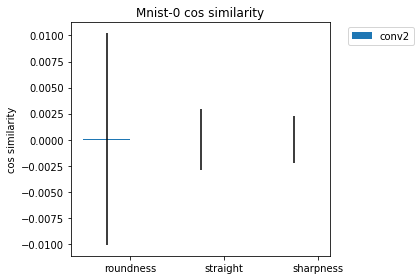

In [50]:
plot_concepts = [ c.split('-')[-1] if c.split('-')[0] == 'imagenet' else c for c in concepts]
for target in targets:
    save_path = root_dir + 'log/' + project_names + '/plot'
    num_bottlenecks = len(bottlenecks)
    num_concepts = len(concepts)
    bar_width = 0.35
    index = np.arange(num_concepts) * bar_width * (num_bottlenecks + 1)
    # matplotlib
    fig, ax = plt.subplots()
    # draw all bottlenecks individually
    for i, [bn, vals] in enumerate(simirarity_score[target].items()):
        bar = ax.bar(index + i * bar_width, vals['mean'],
            bar_width, yerr=vals['std'], label=bn)
    target_class = target.title()
    ax.set_title('{} cos similarity'.format(target_class))
    ax.set_ylabel('cos similarity')
    # ax.set_xlabel(xlabel_name)
    y_range = 0.08
    #ax.set_ylim(-y_range, y_range)
    ax.set_xticks(index + num_bottlenecks * bar_width / 2)
    #plt.xticks(fontsize=8)
    ax.set_xticklabels(plot_concepts)
    ax.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
    fig.tight_layout()
    #plt.savefig(f'{save_path}/{target}:{num_concepts}:cos_similarity.eps')
    plt.show()

In [116]:
target = 'mnist-5'
concept = 'green'
bottleneck = 'conv1'
get_cav_mean(cavs_path, bottleneck, concept)

UnboundLocalError: local variable 'cav_values' referenced before assignment

In [107]:
target = 'mnist-6'
concept = 'sharpness'
bottleneck = 'conv2'
logit_grad = get_logit_grad(cavs_path, bottleneck, target)
cav = get_cav(cavs_path, bottleneck, concept)
s_simi_lst = []
for c in cav:
    s_simi = np.array([cos_sim(lg,c) for lg in logit_grad])
    s_simi_lst.append(s_simi)
print(np.mean(s_simi_lst))
print(np.std(s_simi_lst))

-0.017380300500558273
0.01860870794379353


## Activationについて

In [10]:
acts_path = root_dir + 'log/' + project_names + '/activations'
bottleneck = 'conv1'
concepts = ['mnist_purple','mnist_0']
acts_lst = []
for concept in concepts:
    for dir in os.listdir(acts_path):
        c = dir[5:-6]
        b = dir[-5:]
        if concept == c and bottleneck == b:
            with tf.io.gfile.GFile(acts_path + '/' + dir, 'rb') as f:
                act = np.load(f, allow_pickle=True)
            acts_lst.append(act)